# If a baby in the carseat (medium mode)

In this notebook we'll use [fastai](http://docs.fast.ai) to classify pictures and see if a baby in the carseat inside a car. 

Inspired by https://docs.fast.ai/tutorial.imagenette.html

In [2]:
#!pip install fastai -U

In [1]:
#!pip install torch

In [2]:
#!pip install tensorflow

In [37]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import sys, os, gc

from fastai.vision import *
from fastai.vision.all import *
from fastai.vision.data import ImageDataLoaders
from fastai.metrics import error_rate, accuracy
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report

In [2]:
torch.cuda.get_device_name(0)

'Tesla V100-SXM2-32GB'

In [3]:
device = torch.cuda.device(0)

In [4]:
import tensorflow as tf
print(tf.__version__)
tf.test.is_built_with_cuda()

2.6.0


True

In [5]:
import torch
print(torch.__version__)

1.9.0+cu102


In [6]:
torch.cuda.is_available()

True

## Looking at the data

Our data exists in the `With_baby/` and `Without_baby/` directories. We'll create an `ImageDataBunch` and make sure we can visually tell the difference between kittens and cats.

In [7]:
path = './'

In [8]:
# Preprocessing takes place when creating the databunch
# May need to decrease batch size and num_workers depending on GPU

In [9]:
np.random.seed(1234)
dls = ImageDataLoaders.from_folder(path, train="./image", valid_pct=0.2, 
                                    item_tfms=RandomResizedCrop(128, min_scale=0.35), 
                                    batch_tfms=Normalize.from_stats(*imagenet_stats))

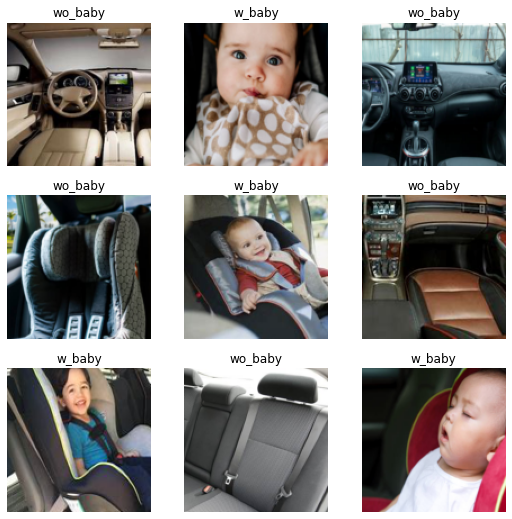

In [10]:
dls.show_batch()

In [11]:
fnames = get_image_files(path)

In [12]:
dblock = DataBlock()

In [13]:
dsets = dblock.datasets(fnames)
dsets.train[0]

(Path('w_baby/OIP (16).jpg'), Path('w_baby/OIP (16).jpg'))

In [14]:
dblock = DataBlock(get_items = get_image_files)

In [15]:
dsets = dblock.datasets(path)
dsets.train[0]

(Path('w_baby/OIP (6).jpg'), Path('w_baby/OIP (6).jpg'))

In [16]:
parent_label(fnames[0])

'w_baby'

In [17]:
#create lable dict
lbl_dict = dict(
    wo_baby='no baby in carseat',
    w_baby   ='a babdy in carseat',
)

In [18]:
def label_func(fname):
    return lbl_dict[parent_label(fname)]

In [19]:
dblock = DataBlock(get_items = get_image_files,
                   get_y     = label_func)

dsets = dblock.datasets(path)
dsets.train[0]

(Path('wo_baby/OIP (36).jpg'), 'no baby in carseat')

In [20]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func)

dsets = dblock.datasets(path)
dsets.train[0]

(PILImage mode=RGB size=612x408, TensorCategory(1))

In [21]:
dsets.vocab

['a babdy in carseat', 'no baby in carseat']

# The last step is to specify item transforms and batch transforms 

In [22]:
torch.cuda.set_device(0)

In [23]:
# dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
#                    get_items = get_image_files,
#                    get_y     = label_func,
#                    splitter  = GrandparentSplitter(),
#                    item_tfms = RandomResizedCrop(128, min_scale=0.35), 
#                    batch_tfms=Normalize.from_stats(*imagenet_stats)
#                    )

In [24]:
imagenette = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items = get_image_files,
                       get_y = Pipeline([parent_label, lbl_dict.__getitem__]),
                       splitter = GrandparentSplitter(valid_name='val'),
                       item_tfms = RandomResizedCrop(128, min_scale=0.35),
                       batch_tfms = Normalize.from_stats(*imagenet_stats))

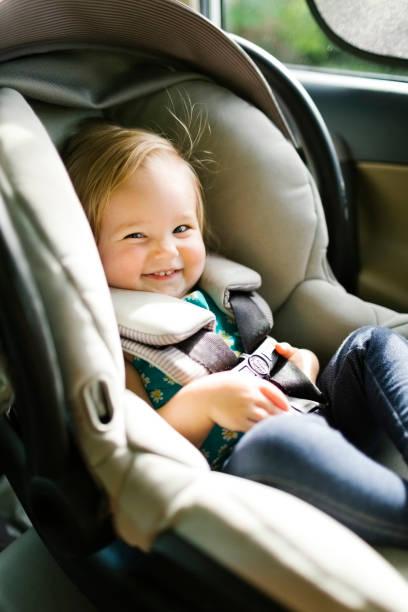

In [25]:
PILImage.create(fnames[10])

In [26]:
#torch.cuda.empty_cache()

## Training a model

Now that we've got our data and it looks correct, let's create a learner for this data. We'll use a ResNet-34 architecture and train for five epochs to get a sense for how we're doing.

In [27]:
learn = vision_learner(dls, resnet34, metrics=accuracy, pretrained=False)

In [28]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.481692,9569.194336,0.419355,00:06
1,1.378628,10695.632812,0.580645,00:06
2,1.231288,133.510620,0.580645,00:05
3,1.066702,9.554398,0.569892,00:06
4,0.985276,1.013977,0.677419,00:05


In [40]:
learn = Learner(dls, xresnet34(n_out=10), metrics= accuracy)

SuggestedLRs(valley=0.0006918309954926372)

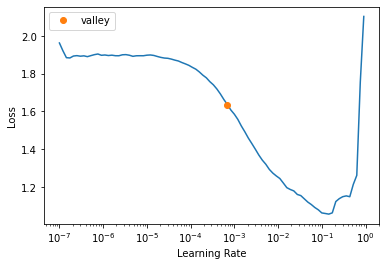

In [41]:
learn.lr_find()

In [42]:
lr = 1e-3  #slice(lr)

In [43]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.761700,1.749195,0.419355,00:06
1,1.329146,1.006804,0.731183,00:06
2,1.034606,1.046147,0.623656,00:06
3,0.867408,0.731163,0.688172,00:06
4,0.747943,0.538181,0.784946,00:06


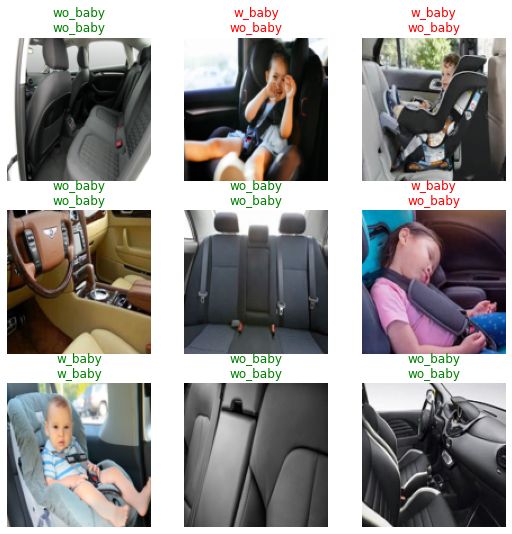

In [44]:
learn.show_results()

In [45]:
learn.unfreeze()

In [46]:
learn.fit_one_cycle(30, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.367530,0.473689,0.827957,00:06
1,0.365539,0.452206,0.849462,00:06
2,0.356304,0.395439,0.849462,00:06
3,0.338101,0.351980,0.827957,00:06
4,0.316401,0.335732,0.838710,00:06
5,0.305747,0.768011,0.774194,00:06
6,0.300972,0.657928,0.763441,00:06
7,0.290281,0.415070,0.838710,00:06
8,0.287714,0.859185,0.731183,00:06
9,0.274628,0.228999,0.881720,00:06


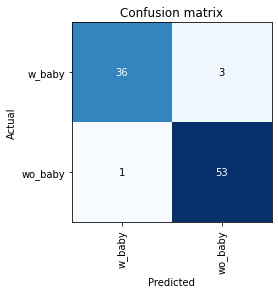

In [47]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [48]:
#learn.load("ai_baby_stage_2")

In [49]:
preds, y, losses = learn.get_preds(with_loss=True)
y_preds = torch.argmax(preds, dim=1)

In [52]:
print(classification_report(y, y_preds, target_names=['without_baby', 'with_baby']))

              precision    recall  f1-score   support

without_baby       0.97      0.92      0.95        39
   with_baby       0.95      0.98      0.96        54

    accuracy                           0.96        93
   macro avg       0.96      0.95      0.96        93
weighted avg       0.96      0.96      0.96        93



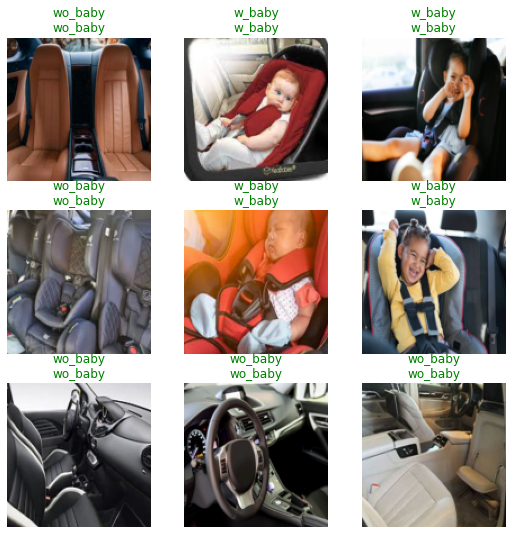

In [53]:
learn.show_results()

In [54]:
learn.save('ai_baby_stage_2')

Path('models/ai_baby_stage_2.pth')

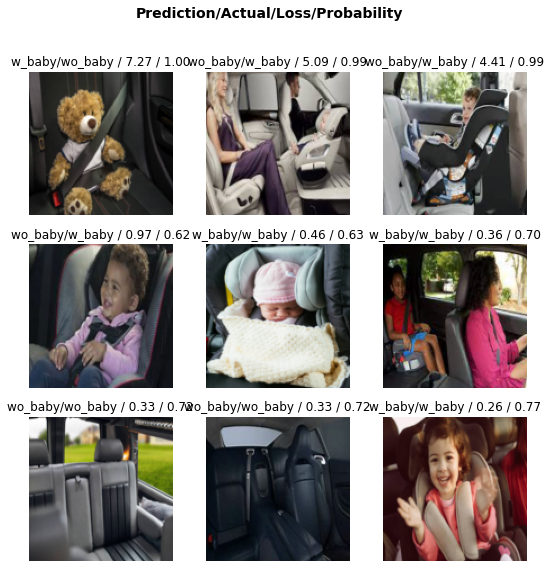

In [55]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)

# discussion
. add more positive images similar to top loss prdicitions, like images with baby from side view <br>
. add more negative images with baby shape stuff toy <br>
. add more negative images with guns/toys